In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import platform

In [2]:
tf.__version__

'2.8.0'

### Data Preprocessing

#### Data download

In [10]:
if platform.platform()[:3].lower() == 'win':
    cache_subdir = 'D:/workspace/Pycharm/tf25/dataset/'
elif platform.platform()[:3].lower() == 'mac':
    cache_subdir = '/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/cats_and_dogs/'

In [11]:
cache_subdir

'D:/workspace/Pycharm/tf25/dataset/'

In [12]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', 
                                      cache_subdir=cache_subdir, 
                                      origin=_URL, extract=True)

68616192/68606236 [==============================] - 1s 0us/step


In [13]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [15]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [21]:
shuffle=False

In [22]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=shuffle,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [23]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                shuffle=shuffle,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


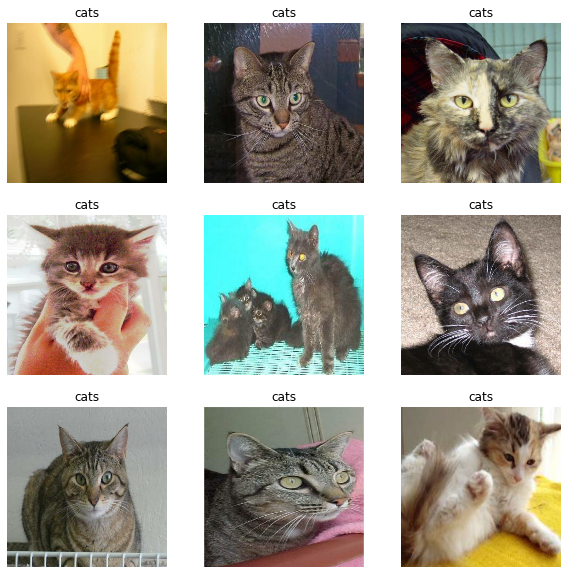

In [24]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])
        plt.axis('off')